In [24]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.applications as keras_apps
import cryptovision.tools as tools
from tensorflow.keras import layers

In [25]:
df = pd.read_csv(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images_catalog.csv'
)

SEED = 42
image_size = (128, 128)
level = 'family'
epochs = 20

def clean_dataframe(df, sample_limit):
    # Rmv duplicates
    df = df.drop_duplicates(subset='hash', keep='first')

    # Rmv Species with less than few images
    df = df[df['species'].map(df['species'].value_counts()) > sample_limit]
    
    df.reset_index(drop=True, inplace=True)
    
    return df

df = clean_dataframe(df, 50)

train_df, val_df, test_df = tools.split_dataframe(
    df,
    test_size=0.15,
    val_size=0.15,
    stratify_by='folder_label',
    random_state=SEED,
)

train_ds = tools.tensorflow_dataset(
    train_df,
    batch_size=128,
    image_size=(128, 128),
)

val_ds = tools.tensorflow_dataset(
    val_df,
    batch_size=128,
    image_size=(128, 128),
)

test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=image_size,
)

train_datasets = {
    'all': train_ds,
    'family': train_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': train_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': train_ds.map(lambda image, labels: (image, labels['species'])),
}

val_datasets = {
    'all': val_ds,
    'family': val_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': val_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': val_ds.map(lambda image, labels: (image, labels['species'])),
}

test_datasets = {
    'all': test_ds,
    'family': test_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': test_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': test_ds.map(lambda image, labels: (image, labels['species'])),
}

In [26]:
# Build Model

# Augmentation
augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.1, seed=SEED),
        layers.RandomZoom(height_factor=(0.05, 0.1), width_factor=(0.05, 0.1), seed=SEED),  # Wider zoom range
        layers.RandomContrast(0.2, seed=SEED),
        layers.RandomBrightness(0.2, seed=SEED),
        layers.RandomTranslation(0.1, 0.1, seed=SEED),
        layers.RandomCrop(image_size[0], image_size[1], seed=SEED),
        layers.GaussianNoise(0.1, seed=SEED),
    ],
    name='augmentation'
)

# Pre-trained Model
pretrain = keras_apps.ResNet50V2(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))
pretrain.trainable = False

def pretrain_model(backbone, preprocess, input_shape=(224, 224, 3), name=None, augmentation=None):
    
    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    x = backbone(x, training=False)
    
    return tf.keras.Model(inputs, x, name=name)

def dense_block(input_layer, name:str, units:int, dropout:float, activation:str='relu', norm:bool=True):
    
    x = layers.Dense(units, name=name)(input_layer)
    if norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout)(x)
    return x

feature_extractor = pretrain_model(
    pretrain, 
    keras_apps.resnet_v2.preprocess_input, 
    input_shape=(image_size[0], image_size[1], 3), 
    name='feature_extractor',
    augmentation=augmentation
)

# Eviota Model
features = layers.GlobalAveragePooling2D(name='GlobAvgPool2D')(feature_extractor.output)
hidden_layer = dense_block(features, 'hidden_layer', 1024, 0.2)

# Species Output
species_output = layers.Dense(df[level].nunique(), activation='softmax', name='species')(hidden_layer)

model = tf.keras.Model(
    feature_extractor.input,
    species_output,
    name='LevelModel_' + level
)

model.summary()

Model: "LevelModel_family"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_8 (Cast)                   │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_6 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_6 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobAvgPool2D                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ species (Dense)                 │ (None, 19)             │        19,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,686,547 (97.99 MB)

 Trainable params: 2,119,699 (8.09 MB)

 Non-trainable params: 23,566,848 (89.90 MB)

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [28]:
history = model.fit(
    train_datasets[level],
    epochs=epochs,
    validation_data=val_datasets[level],
    verbose=1,
)

Epoch 1/20


2025-02-10 18:05:09.042129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:170: Filling up shuffle buffer (this may take a while): 34 of 10872
2025-02-10 18:05:24.073309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 374ms/step - accuracy: 0.2130 - loss: 2.7454 - val_accuracy: 0.4592 - val_loss: 1.8197
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.4470 - loss: 1.8418 - val_accuracy: 0.5052 - val_loss: 1.6239
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.4878 - loss: 1.6654 - val_accuracy: 0.5391 - val_loss: 1.5230
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 265ms/step - accuracy: 0.5054 - loss: 1.5833 - val_accuracy: 0.5382 - val_loss: 1.4958
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 263ms/step - accuracy: 0.5150 - loss: 1.5368 - val_accuracy: 0.5485 - val_loss: 1.4613
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - accuracy: 0.5274 - loss: 1.4804 - val_accuracy: 0.5433 - val_loss: 1.4460
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 275ms/step - accuracy: 0.5446 - loss: 1.4293 - val_accuracy: 0.5506 - val_loss: 1.4375
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 263ms/step - accuracy: 0.5485 - loss: 1.3956 - val_accuracy: 0.554

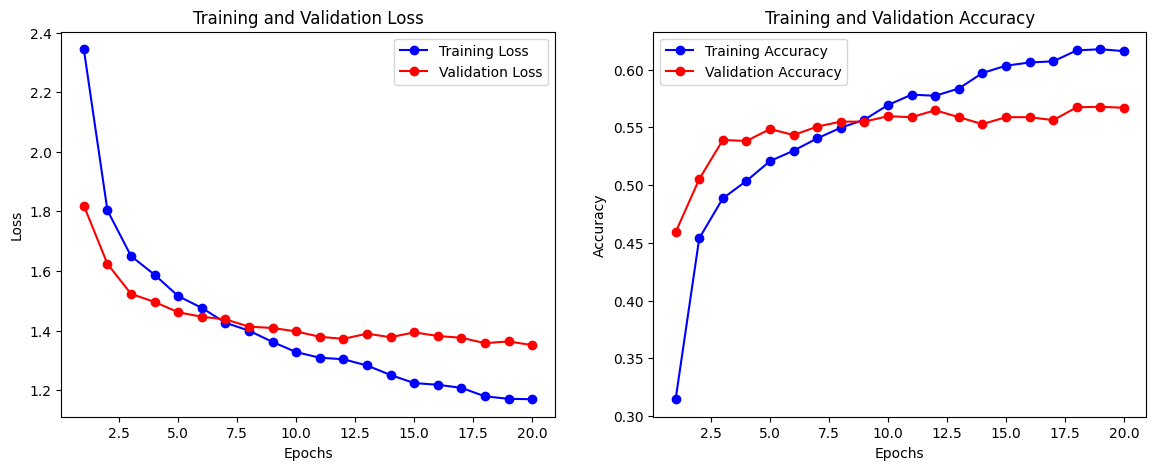

In [29]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from a Keras History object.
    
    Parameters:
    -----------
    history : keras.callbacks.History
        The History object returned by model.fit().
    """
    # Retrieve metrics from the history object
    acc      = history.history.get('accuracy', [])
    val_acc  = history.history.get('val_accuracy', [])
    loss     = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Create subplots for loss and accuracy
    plt.figure(figsize=(14, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Example usage:
plot_training_history(history)


In [15]:
test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=(224, 224),
)

test_ds_sp = test_ds.map(lambda image, labels: (image, labels['species']))

In [ ]:
# Specialist Based Model
def specialist(backbone, preprocess, input_shape, output_units, augmentation=None):

    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    
    
    # Family Specialist
    fam_features = backbone(x, training=False)
    fam_features = layers.GlobalAveragePooling2D()(fam_features)
    fam_hidden = dense_block(fam_features, 1024, 0.3, 'family_hidden')
    family_output = layers.Dense(output_units[0], activation='softmax', name='family')(fam_hidden)
    
    # Genus Specialist
    genus_features = backbone(x, training=False)
    genus_features = layers.GlobalAveragePooling2D()(genus_features)
    genus_hidden = dense_block(genus_features, 512, 0.3, 'genus_hidden')
    genus_output = layers.Dense(output_units[1], activation='softmax', name='genus')(genus_hidden)
    
    # Species Specialist
    species_features = backbone(x, training=False)
    species_features = layers.GlobalAveragePooling2D()(species_features)
    species_hidden = dense_block(species_features, 512, 0.3, 'species_hidden')
    species_output = layers.Dense(output_units[2], activation='softmax', name='species')(species_hidden)
    
    model = tf.keras.Model(
        inputs,
        [family_output, genus_output, species_output],
        name='Specialist'
    )
    
    return model
    